# **SPE CGS Machine Learning challenge**

 **Team name: Data Driller**

**Team members:**
Ghulam Haider |
Muhammad Wajeeh Arif |
Furqan Rashid |
Shamsa Batool


**Problem Statement**: Generation of sonic logs from other well-logs

**Problem Description:**

 **Type:** Supervised learning problem

**Formulation:**   Predict sonic log through a non-linear mapping between features (various well-logs)
 
 **Inputs:** Available well logs ( Porosity, Gamma Ray, Resistivity & Compressional slowness)

 **Output:** DTSM

 **Data Sponsor: TGS**

In [1]:
pip install lasio

## **Importing libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
from keras.models import Sequential
import glob
import lasio
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import  enable_iterative_imputer
from sklearn.impute import KNNImputer
from keras.layers.core import Dense, Dropout, Activation

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Reading 234 las files well logs**


In [4]:
data_234=[]    
path='/content/gdrive/MyDrive/ML Challenge Data/*.*'
for file in glob.glob(path):   
                G=lasio.read(file)     #reading las files with Lasio 
                data_234.append(G)     #appending it to data_234 (list)
print("No of files :",len(data_234))   

No of files : 234


In [5]:
for i, curve in enumerate(data_234[6].curves):                                                                   
    print(f"curve: {curve.mnemonic}, units: {curve.unit}, description: {curve.descr}")

curve: DEPT, units: FT, description: DEPTH FEET
curve: DPHZ_LS, units: DEC, description: DENSITY POROSITY LIMESTONE [M=2.71, F=1] FROM CNL-LDT LOG
curve: DTCO, units: US/F, description: DELTA TIME FROM DAC LOG
curve: DTSM, units: US/F, description: DELTA TIME FROM DAC LOG
curve: GRD, units: GAPI, description: GAMMA RAY FROM CNL-LDT LOG
curve: GRR, units: GAPI, description: GAMMA RAY FROM ALAT-MCFL LOG
curve: GRS, units: GAPI, description: GAMMA RAY FROM DAC LOG
curve: HCALR, units: IN, description: HRCC CALIPER FROM ALAT-MCFL LOG
curve: HDRA, units: G/C3, description: DENSITY CORRECTION FROM CNL-LDT LOG
curve: HLLD, units: OHMM, description: DEEP LATEROLOG RESISTIVITY FROM ALAT-MCFL LOG
curve: HLLS, units: OHMM, description: SHALLOW LATEROLOG RESISTIVITY FROM ALAT-MCFL LOG
curve: PEFZ, units: B/E, description: PHOTOELECTRIC FACTOR STANDARD RESOLUTION FROM CNL-LDT LOG
curve: PR, units: UNITLESS, description: POISSON RATIO FROM DAC LOG
curve: RHOB, units: G/C3, description: BULK DENSITY 

Converting all 234 well logs data from data_234 to data frame as w1, w2, w3,......, w234 

In [6]:
for i in range(234):
        locals()['w'+str(i+1)]= data_234[i].df() 

# **Exploratory data analysis**

 **Heat map correlation of some of the well logs**

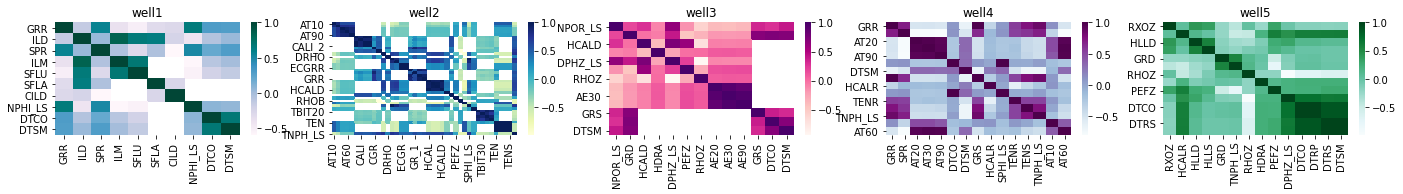

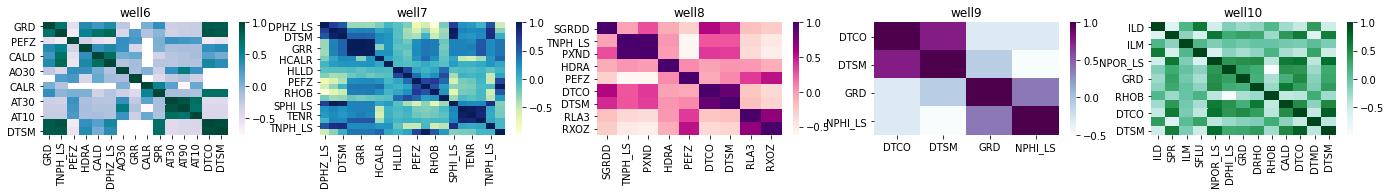

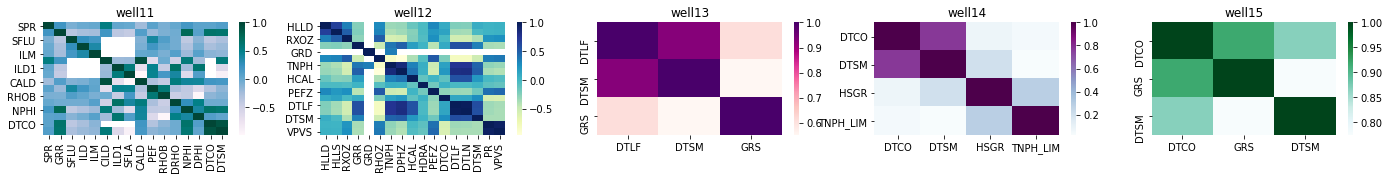

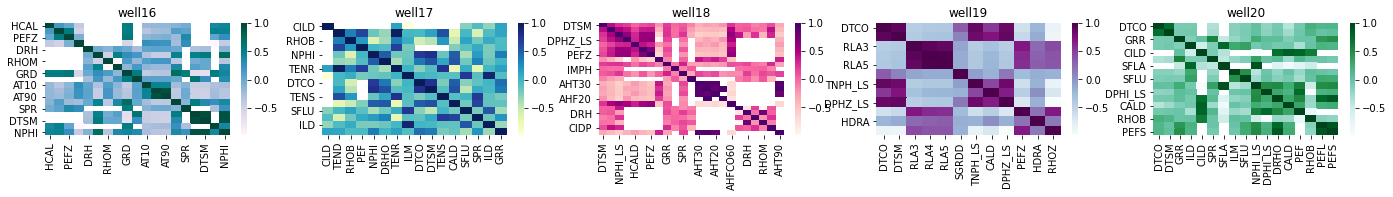

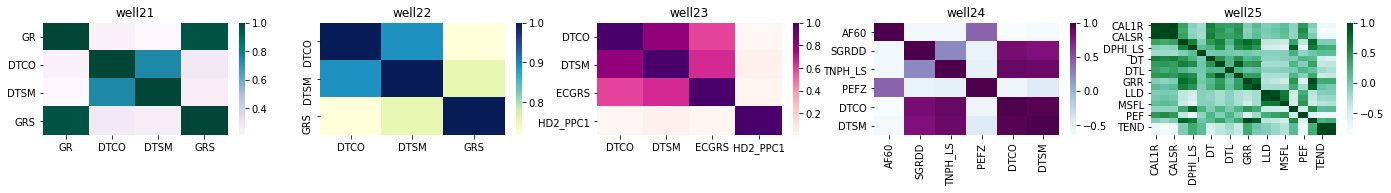

In [7]:
for i in range(0,21,5):                         
        plt.figure(figsize=(24,12))

        plt.subplot(5,5,1)
        plt.title('well'+str(i+1))       
        sns.heatmap(locals()['w'+str(i+1)].corr(),cmap="PuBuGn");
      
        plt.subplot(5,5,2)
        plt.title('well'+str(i+2))       
        sns.heatmap(locals()['w'+str(i+2)].corr(),cmap="YlGnBu");

        plt.subplot(5,5,3)        
        plt.title('well'+str(i+3))       
        sns.heatmap(locals()['w'+str(i+3)].corr(),cmap="RdPu");
    
        plt.subplot(5,5,4)
        plt.title('well'+str(i+4))       
        sns.heatmap(locals()['w'+str(i+4)].corr(),cmap="BuPu");
        
        plt.subplot(5,5,5)
        plt.title('well'+str(i+5))       
        sns.heatmap(locals()['w'+str(i+5)].corr(),cmap="BuGn");

# Relationship of DTSM with DTCO

DTCO vs DTSM for ten well logs

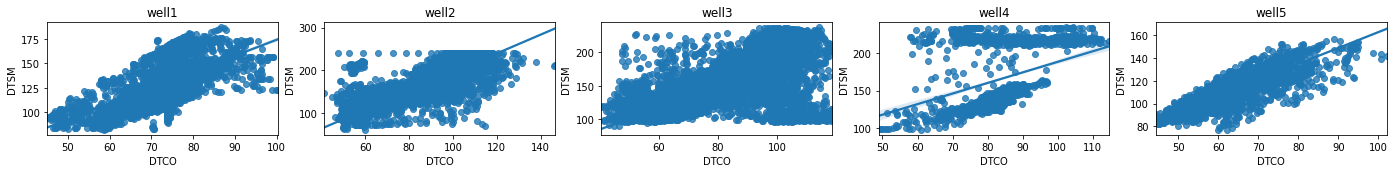

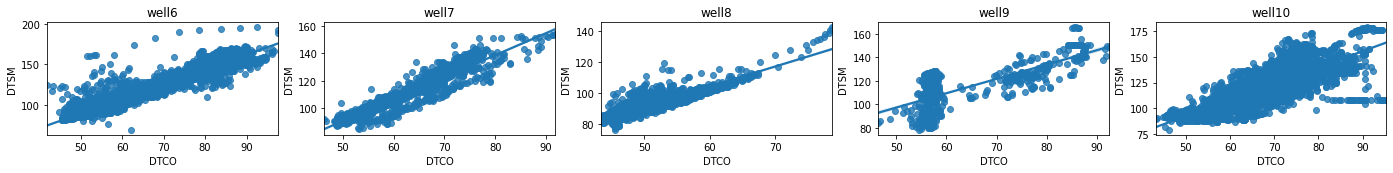

In [8]:
for i in range(0,10,5):     
        plt.figure(figsize=(24,12))

        plt.subplot(5,5,1)      
        plt.title('well' +str(i+1) )
        d=locals()['w'+str(i+1)]
       
        sns.regplot(x=d.DTCO,y=d.DTSM,data=d);
      
        plt.subplot(5,5,2)
        plt.title('well' +str(i+2) )
        d=locals()['w'+str(i+2)]
        sns.regplot(x=d.DTCO,y=d.DTSM,data=d)
      

        plt.subplot(5,5,3)  
        plt.title('well' +str(i+3) )      
        d=locals()['w'+str(i+3)]
       
        sns.regplot(x=d.DTCO,y=d.DTSM,data=d)
    
        plt.subplot(5,5,4)
        plt.title('well' +str(i+4) )
        d=locals()['w'+str(i+4)]
    
        sns.regplot(x=d.DTCO,y=d.DTSM,data=d)
        
        plt.subplot(5,5,5)
        plt.title('well' +str(i+5) )
        d=locals()['w'+str(i+5)]
        sns.regplot(x=d.DTCO,y=d.DTSM,data=d)

Regression plot is indicating that DTSM is increasing as DTCO is increasing. 

Now changing the column name NPOR_LS and NPHI_LS to NPHI in all 234 dataframes.

In [9]:
for i in range(234):
    Np=locals()['w'+str(i+1)]  
    
    if pd.Series(['NPOR_LS']).isin(Np.columns).any():
         Np.rename(columns={'NPOR_LS': 'NPHI'}, inplace=True)             #chaning colummn name from NPOR_LS to NPHI in all 234 well logs
        
    
    elif pd.Series(['NPHI_LS']).isin(Np.columns).any():                   
         Np.rename(columns={'NPHI_LS': 'NPHI'}, inplace=True)             #chaning colummn name from NPHI_LS to NPHI in all 234 well logs

Name of data frame that contain NPHI and DTSM so that we can find relationship between NPHI and DTSM.

In [10]:
for i in range(20):
    N_D=locals()['w'+str(i+1)]  
    if pd.Series(['NPHI','DTSM']).isin(N_D.columns).all():
              print('w'+str(i+1))        #dataframe that contain NPHI and DTSM from w1 to w20

w1
w3
w9
w10
w11
w16
w17
w18
w20


# Relationship of DTSM with NPHI
NPHI vs DTSM for ten well logs

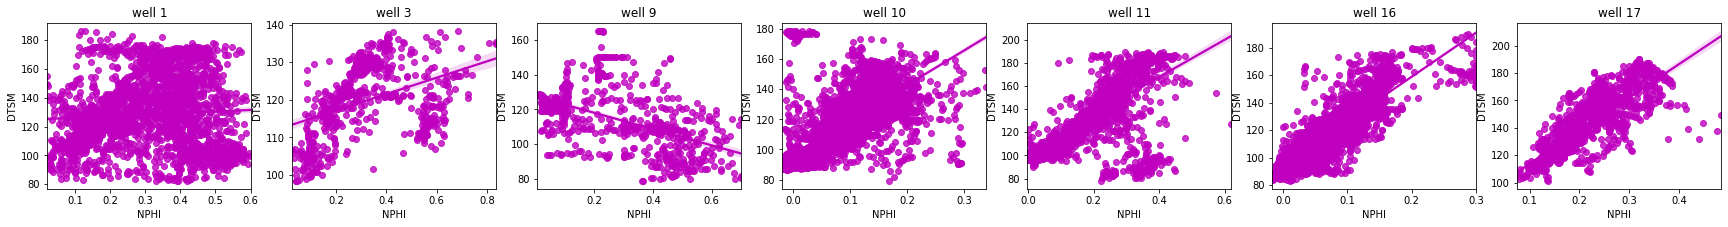

In [11]:
plt.figure(figsize=(30,25))

plt.subplot(7,7,1) 
plt.title('well 1')           
sns.regplot(x=w1.NPHI,y=w1.DTSM,data=w1,color='m',);
      
plt.subplot(7,7,2)
plt.title('well 3')  
sns.regplot(x=w3.NPHI,y=w3.DTSM,data=w3,color='m')

plt.subplot(7,7,3)  
plt.title('well 9')        
sns.regplot(x=w9.NPHI,y=w9.DTSM,data=w9,color='m')

plt.subplot(7,7,4)
plt.title('well 10')  
sns.regplot(x=w10.NPHI,y=w10.DTSM,data=w10,color='m')

plt.subplot(7,7,5) 
plt.title('well 11')  
sns.regplot(x=w11.NPHI,y=w11.DTSM,data=w11,color='m')

plt.subplot(7,7,6) 
plt.title('well 16')  
sns.regplot(x=w16.NPHI,y=w16.DTSM,data=w16,color='m')

plt.subplot(7,7,7) 
plt.title('well 17')  
sns.regplot(x=w17.NPHI,y=w17.DTSM,data=w17,color='m')

DTSM has higher values for higher values of NPHI in most of the cases.

Names of well logs that contain GRD,GRR and GRS

In [12]:
for i in range(30):
    G=locals()['w'+str(i+1)]  
    if pd.Series(['GRD','GRR','GRS']).isin(G.columns).all():
              print('w'+str(i+1))                          #dataframe that contain GRD,GRR and GRS from w1 to w30

w7


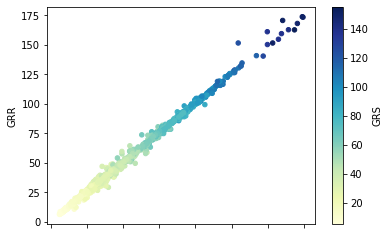

In [13]:
w7.plot(kind="scatter", x="GRD", y="GRR" ,c='GRS', colormap="YlGnBu")
plt.show()

In [15]:
for i in range(20):
    R=locals()['w'+str(i+1)]  
    if pd.Series(['RHOB','DTSM']).isin(R.columns).all():
              print('w'+str(i+1))          

w2
w7
w10
w11
w17
w20


# Relationship of DTSM with RHOB

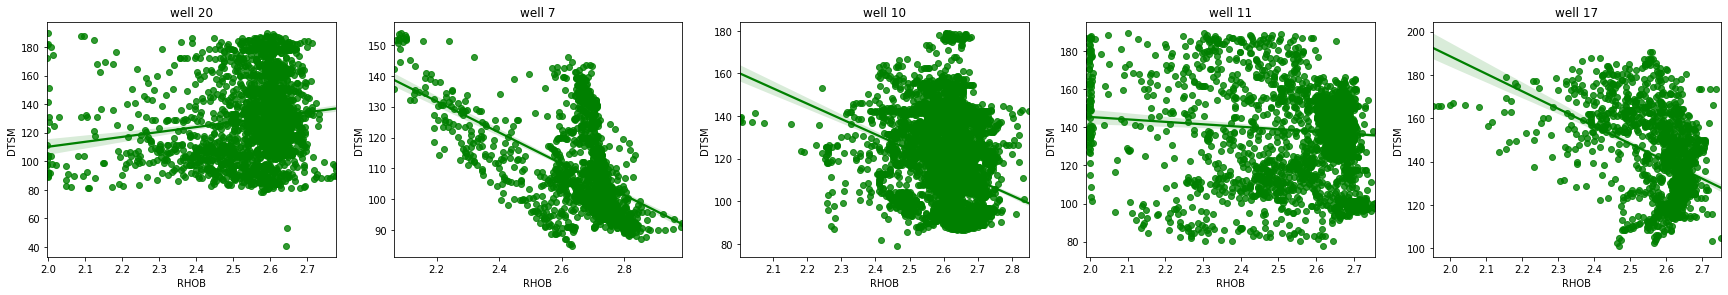

In [17]:
plt.figure(figsize=(30,25))
plt.subplot(5,5,1) 
plt.title('well 20')           
sns.regplot(x=w20.RHOB,y=w20.DTSM,data=w20,color='g');
      
plt.subplot(5,5,2)
plt.title('well 7')
sns.regplot(x=w7.RHOB,y=w7.DTSM,data=w7,color='g')

plt.subplot(5,5,3)
plt.title('well 10')
sns.regplot(x=w10.RHOB,y=w10.DTSM,data=w10,color='g')

plt.subplot(5,5,4) 
plt.title('well 11')
sns.regplot(x=w11.RHOB,y=w11.DTSM,data=w11,color='g')

plt.subplot(5,5,5)  
plt.title('well 17')      
sns.regplot(x=w17.RHOB,y=w17.DTSM,data=w17,color='g')


# **Train data selection and cleaning**

In [18]:
A= pd.Series(['DTCO','GRD','RHOB','NPHI','DTSM'])    
data_A=[]                                            #DTCO','GRD','RHOB','NPHI','DTSM'

B = pd.Series(['DTCO','GRR','RHOB','NPHI','DTSM'])    
data_B=[]                                            #DTCO','GRR','RHOB','NPHI','DTSM'

for i in range(234):
    X=locals()['w'+str(i+1)]  
    if A.isin(X.columns).all():
            data_A.append('w'+ str(i+1))  #data frame that contain these columns DTCO,GRD,RHOB,NPHI,DTSM
        
    elif B.isin(X.columns).all() and not A.isin(X.columns).all():  #data frame that contain these columns DTCO,GRR,RHOB,NPHI 
            data_B.append('w'+ str(i+1))
            
    i+=1     
print("Name of Wells that contain DTCO,'GRD,RHOB,NPHI and DTSM : ",data_A)
print()
print("Name of Wells that contain DTCO,'GRR,RHOB,NPHI and DTSM : ",data_B)

Name of Wells that contain DTCO,'GRD,RHOB,NPHI and DTSM :  ['w10', 'w30', 'w34', 'w45', 'w52', 'w54', 'w66', 'w81', 'w84', 'w95', 'w111', 'w137', 'w147', 'w152', 'w176', 'w186', 'w191', 'w197', 'w200', 'w208', 'w209', 'w216', 'w219']

Name of Wells that contain DTCO,'GRR,RHOB,NPHI and DTSM :  ['w11', 'w17', 'w20', 'w40', 'w43', 'w44', 'w46', 'w47', 'w55', 'w57', 'w65', 'w68', 'w70', 'w85', 'w91', 'w104', 'w110', 'w112', 'w115', 'w119', 'w125', 'w141', 'w160', 'w166', 'w169', 'w175', 'w183', 'w199', 'w207', 'w212', 'w217', 'w225', 'w229']


In [19]:
a = pd.concat([w10, w30, w34, w45, w52, w54, w66, w81, w84, w95, w111,w137,w147, w152, w176, w186,
               w191,w197, w200, w208,w209,w216,w219])    #  Wells that contain DTCO,'GRD,RHOB,NPHI and DTSM
 
train_data_a=a[A]                      # A is pd.Series(['DTCO','GRD','RHOB','NPHI','DTSM'])    
train_data_a=train_data_a.dropna()     #droping rows that contain null values. 
  

b = pd.concat([w11,w17,w20,w40, w43, w44, w46, w47, w55, w57, w65, w68, w70, w85, w91, w104 , w110,w112,w115,  w119, w125,
               w141, w160,w166, w169, w175, w183, w199, w207, w212, w217, w225, w229])   #  Wells that contain DTCO,'GRR,RHOB,NPHI and DTSM
  

train_data_b=b[B]                       # B is pd.Series(['DTCO','GRR','RHOB','NPHI','DTSM']) 
train_data_b=train_data_b.dropna()       #droping rows that contain null values. 

In [20]:
train_data_a.columns=['DTCO', 'GR', 'RHOB', 'NPHI', 'DTSM']
train_data_b.columns=['DTCO', 'GR', 'RHOB', 'NPHI', 'DTSM']
Train_Data=train_data_a.append(train_data_b)
Train_Data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 240217 entries, 15505.0 to 10590.5
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   DTCO    240217 non-null  float64
 1   GR      240217 non-null  float64
 2   RHOB    240217 non-null  float64
 3   NPHI    240217 non-null  float64
 4   DTSM    240217 non-null  float64
dtypes: float64(5)
memory usage: 11.0 MB


In [21]:
Train_Data.describe()

,DTCO,GR,RHOB,NPHI,DTSM
count,240217.000000,240217.000000,240217.000000,240217.000000,240217.000000
mean,65.690820,71.797883,2.593209,0.133043,117.590301
std,13.942599,44.214610,0.167333,0.103625,27.880136
min,33.895000,1.151500,1.057800,-0.390200,40.615300
25%,54.764600,34.513100,2.531600,0.044200,97.210800
50%,63.397700,70.332500,2.624000,0.121100,110.282900
75%,74.400600,101.479700,2.678600,0.207500,130.891200
max,200.964900,623.161700,4.017300,0.700000,235.289100


##**Reading 20 Las files of Test Wells  (Target wells for DTSM prediction)**



In [22]:
test_data=[]    
path= '/content/gdrive/MyDrive/ML Challenge All Test Data/*.*'
for file in glob.glob(path):   
              print(file) 
              T=lasio.read(file)   
              test_data.append(T) 
print("\nNo of files in test data: ",len(test_data))     



/content/gdrive/MyDrive/ML Challenge All Test Data/302460e3021a_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/0a7822c59487_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/3369b6f8fb6f_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/638f2cc65681_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/7595ba9fb314_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/84c5fb9cc880_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/8e37531ba266_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/94c1f5cae85c_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/ed48bda2217f_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/34a80ab7a5fa_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/00d02be79f49_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/113412eec2a6_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/1684cc35f399_TGS.las
/content/gdrive/MyDrive/ML Challenge All Test Data/20372701d5e2_

Converting test well logs to data frame from W1 to W20 

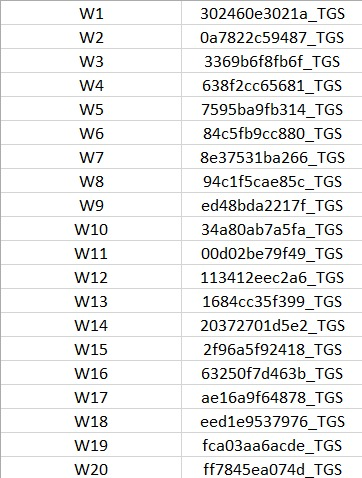

In [23]:
for i in range(20):
        locals()['W'+str(i+1)]= test_data[i].df() 

# **Test data infomation**

# Heat map correlation test well logs

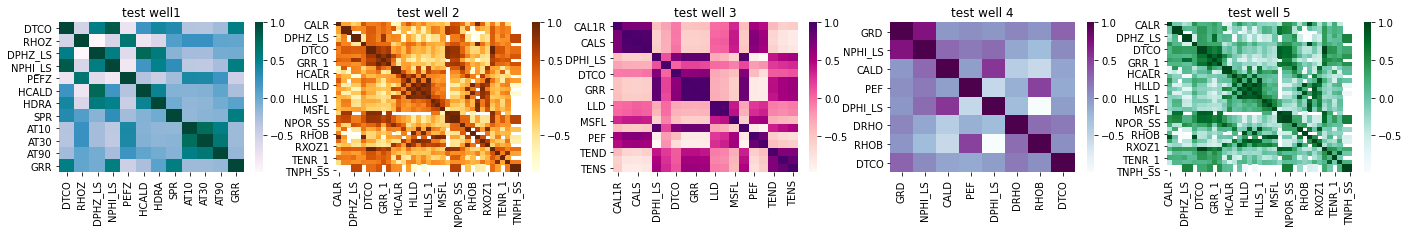

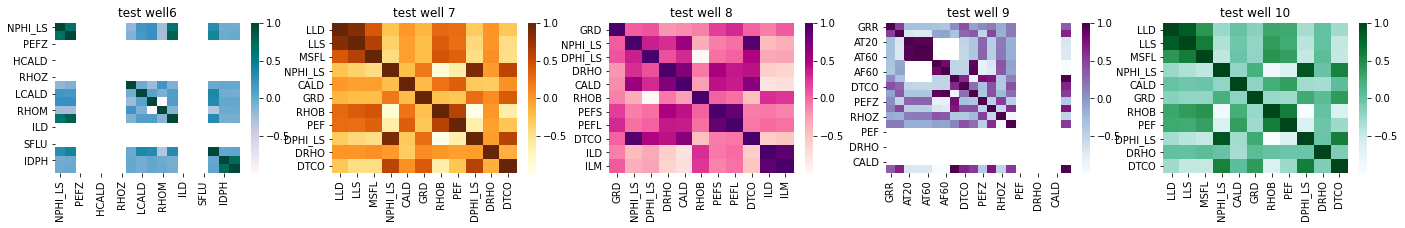

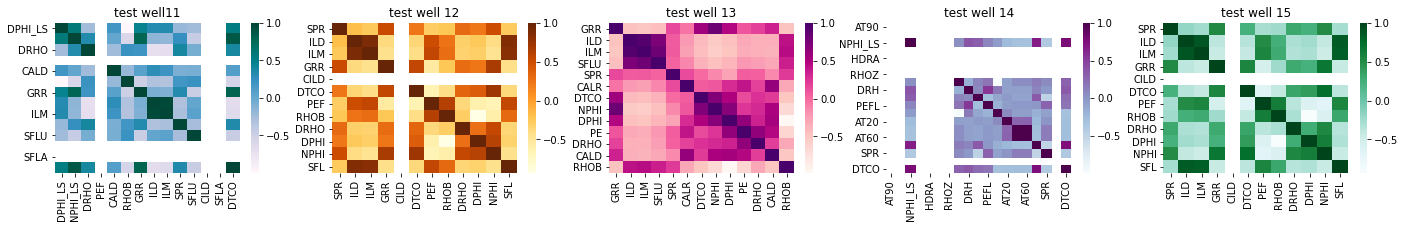

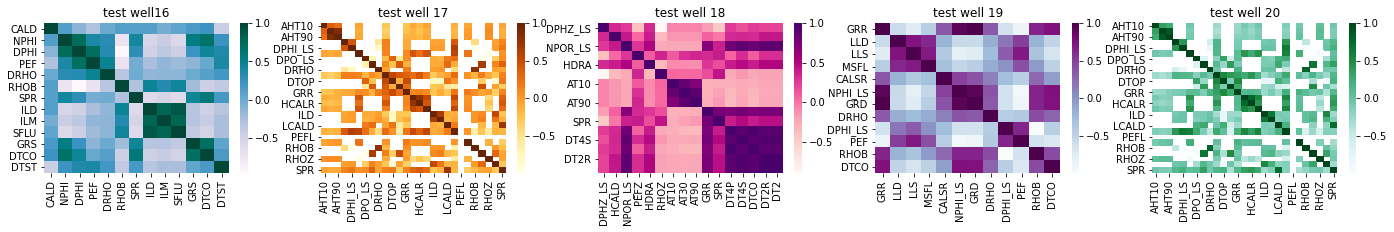

In [24]:
for i in range(0,16,5):
        plt.figure(figsize=(24,16))
        plt.subplot(5,5,1)
        plt.title('test well'+str(i+1))       
        sns.heatmap( locals()['W'+str(i+1)].corr(),cmap="PuBuGn");
         
        plt.subplot(5,5,2)       
        plt.title('test well '+str(i+2))       
        sns.heatmap(locals()['W'+str(i+2)].corr(),cmap="YlOrBr");

        plt.subplot(5,5,3)
        plt.title('test well '+str(i+3))       
        sns.heatmap(locals()['W'+str(i+3)].corr(),cmap="RdPu");
    
        plt.subplot(5,5,4)   
        plt.title('test well '+str(i+4))    
        sns.heatmap(locals()['W'+str(i+4)].corr(),cmap="BuPu");

        plt.subplot(5,5,5)        
        plt.title('test well '+str(i+5))       
        sns.heatmap(locals()['W'+str(i+2)].corr(),cmap="BuGn");  

In [25]:
all_test_data=[W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20]
result = pd.concat(all_test_data)
result.columns

Index(['DTCO', 'RHOZ', 'DPHZ_LS', 'NPHI_LS', 'PEFZ', 'HCALD', 'HDRA', 'SPR',
       'AT10', 'AT30', 'AT90', 'GRR', 'CALR', 'DPHI_LS', 'DPHI_SS', 'DPHZ_SS',
       'DRHO', 'DTRP', 'GRD', 'GRR_1', 'GRS', 'HCALR', 'HCALR_1', 'HLLD',
       'HLLD1', 'HLLS', 'HLLS_1', 'LLD', 'LLS', 'MSFL', 'NPHI_SS', 'NPOR_LS',
       'NPOR_SS', 'PEF', 'RHOB', 'RXOZ', 'RXOZ1', 'SPHI_LS', 'TEND', 'TENR_1',
       'TENS', 'TNPH_LS', 'TNPH_SS', 'CAL1R', 'CALD', 'CALS', 'CALSR', 'TENR',
       'SFLU', 'ILD', 'ILM', 'NPHI', 'DRH', 'LCALD', 'DPO_LS', 'RHOM', 'IDPH',
       'IMPH', 'PEFS', 'PEFL', 'AT20', 'AT60', 'AF20', 'AF60', 'AFCO', 'HCAL',
       'DPHZ', 'DPHI', 'GR', 'CILD', 'SFLA', 'SFL', 'PE', 'DPO', 'LCALR',
       'AHFCO60', 'AHT20', 'AHT30', 'AHT60', 'AHF20', 'AHF60', 'AHT90', 'DTST',
       'AHT10', 'DTOP', 'DTOS', 'DT4P', 'DT4S', 'DT2R', 'DT2'],
      dtype='object')

Now changing the column name NPOR_LS and NPHI_LS to NPHI in all test well log dataframes.

In [26]:
for i in range(20):
    
    NP=locals()['W'+str(i+1)]  
    
    if pd.Series(['NPOR_LS']).isin(NP.columns).any():
         NP.rename(columns={'NPOR_LS': 'NPHI'}, inplace=True)    #chaning colummn name from NPOR_LS to NPHI in 20 test well logs
             
    elif pd.Series(['NPHI_LS']).isin(NP.columns).any():
         NP.rename(columns={'NPHI_LS': 'NPHI'}, inplace=True)      #chaning colummn name from NPHI_LS to NPHI in 20 test well logs

#  Test data cleaning and selection

# Droping columns 



In [27]:
for i in range(20):                                                         

        locals()['W'+str(i+1)].drop(['DPHZ_LS', 'PEFZ', 'HCALD', 'HDRA', 'SPR', 'AT10', 'AT30', 'AT90', 'CALR', 'DPHI_LS', 
                               'DPHI_SS', 'DPHZ_SS','DRHO', 'DTRP', 'GRR_1', 'HCALR', 'HCALR_1', 'HLLD','HLLD1', 'HLLS', 'HLLS_1', 
                               'LLD', 'LLS', 'MSFL','PEF', 'RXOZ', 'RXOZ1', 'SPHI_LS', 'TEND', 'TENR_1','TENS', 'TNPH_LS', 'TNPH_SS', 
                               'CAL1R', 'CALD', 'CALS', 'CALSR', 'TENR','SFLU', 'ILD', 'ILM', 'DRH', 'LCALD', 'DPO_LS', 'IDPH', 'IMPH', 
                               'PEFS', 'PEFL', 'AT20', 'AT60', 'AF20', 'AF60', 'AFCO', 'HCAL','DPHZ', 'DPHI', 'CILD', 'SFLA', 'SFL', 'PE', 
                               'DPO', 'LCALR','AHFCO60', 'AHT20', 'AHT30', 'AHT60', 'AHF20', 'AHF60', 'AHT90', 'DTST','AHT10', 'DTOP', 'DTOS',
                                'DT4P', 'DT4S', 'DT2R', 'DT2'], axis=1, inplace=True,errors='ignore')
         
         #if 20 test well logs contain any of the columns name, it will be removed


# **Handling null values**
null value information

In [28]:
for i in range(20):
   print('Null values in test well '+str(i+1))
   print(locals()['W'+str(i+1)].isnull().sum().sort_values(ascending=False))

Null values in test well 1
RHOZ    84
DTCO     8
GRR      0
NPHI     0
dtype: int64
Null values in test well 2
RHOZ       4940
NPHI_SS    3280
RHOB       1050
NPOR_SS     936
NPHI        936
GRD         882
GRS          70
DTCO         24
dtype: int64
Null values in test well 3
GRS     70
RHOB     0
NPHI     0
GRR      0
GRD      0
DTCO     0
dtype: int64
Null values in test well 4
GRD     44
DTCO     0
RHOB     0
NPHI     0
dtype: int64
Null values in test well 5
GRS     41
NPHI     0
RHOB     0
GRD      0
GRR      0
DTCO     0
dtype: int64
Null values in test well 6
RHOZ    1291
DTCO       1
GRR        0
RHOM       0
NPHI       0
dtype: int64
Null values in test well 7
RHOB    264
GRD     108
NPHI     90
DTCO      2
dtype: int64
Null values in test well 8
NPHI    1117
GRD       24
DTCO       0
RHOB       0
dtype: int64
Null values in test well 9
RHOB    24122
RHOZ    11101
NPHI    11091
DTCO        0
GRR         0
dtype: int64
Null values in test well 10
GR      1594
NPHI      91
GRR

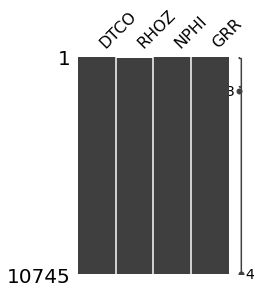

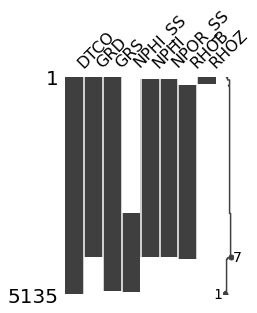

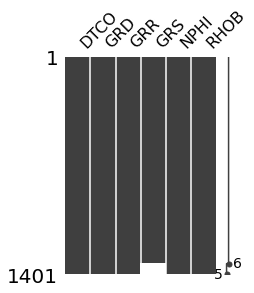

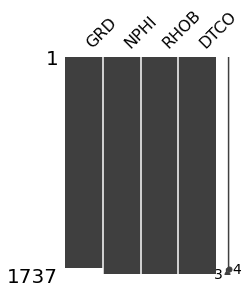

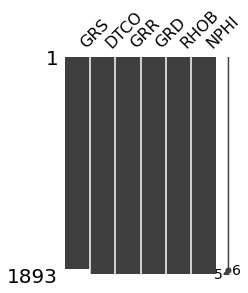

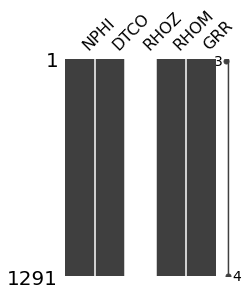

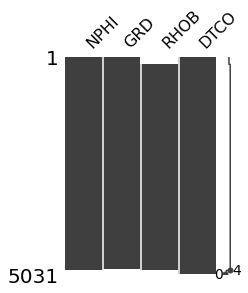

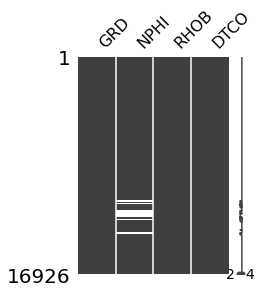

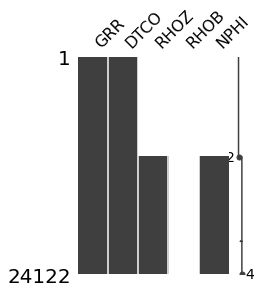

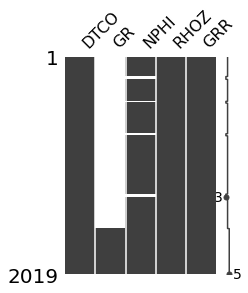

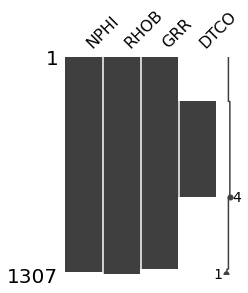

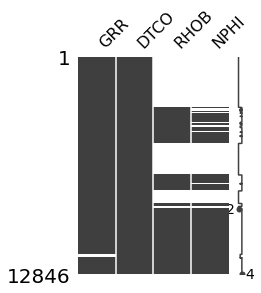

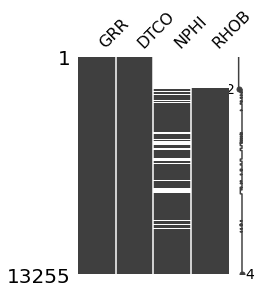

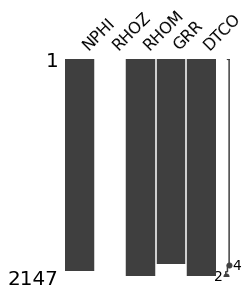

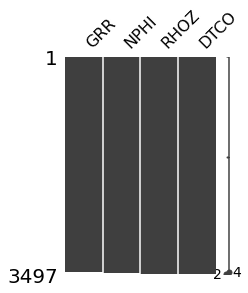

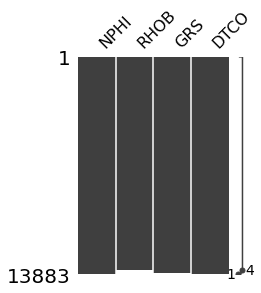

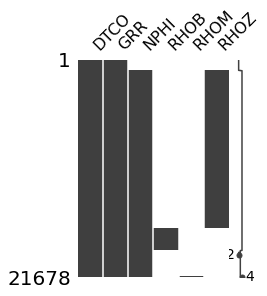

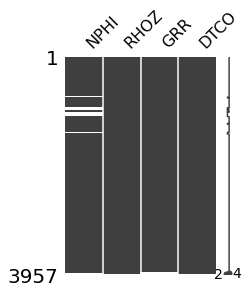

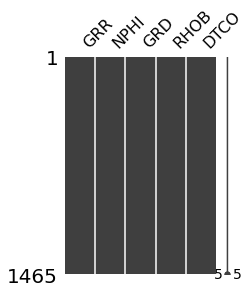

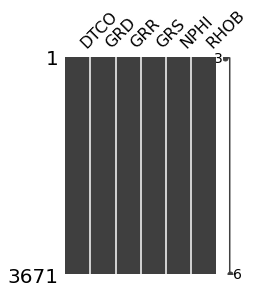

In [29]:
for i in (0,5,10,15):
        msno.matrix(locals()['W'+str(i+1)],figsize=(3, 4))       
        msno.matrix(locals()['W'+str(i+2)],figsize=(3, 4))
        msno.matrix(locals()['W'+str(i+3)],figsize=(3, 4))
        msno.matrix(locals()['W'+str(i+4)],figsize=(3, 4))     
        msno.matrix(locals()['W'+str(i+5)],figsize=(3, 4))

# filling with from correspoing columns of W2 and W17

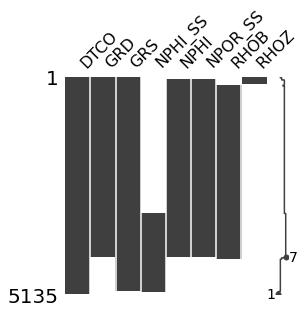

In [30]:
msno.matrix(W2,figsize=(4, 4))       #W2 null values

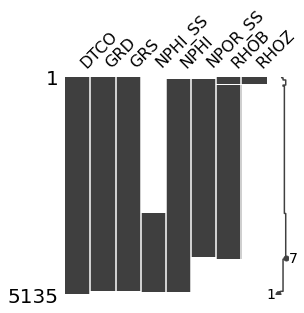

In [31]:
W2['NPHI'].fillna(W2['NPHI_SS'],inplace=True)
W2['RHOB'].fillna(W2['RHOZ'],inplace=True)
W2['GRD'].fillna(W2['GRS'],inplace=True)
msno.matrix(W2,figsize=(4, 4))

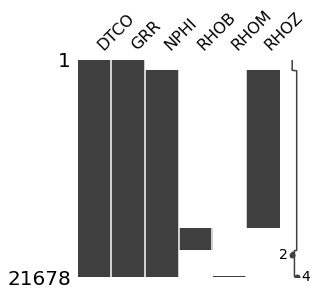

In [32]:
msno.matrix(W17,figsize=(4, 4))

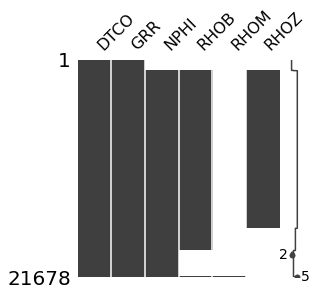

In [33]:
W17['RHOB'].fillna(W17['RHOM'],inplace=True)
W17['RHOB'].fillna(W17['RHOZ'],inplace=True)
msno.matrix(W17,figsize=(4, 4))

In [34]:
W14['RHOZ'].fillna(W14['RHOM'],inplace=True)

# **Test data selection**


In [35]:
W1=W1[['DTCO','GRR','RHOZ','NPHI']]
W2=W2[['DTCO','GRD','RHOB','NPHI']]
W3=W3[['DTCO','GRD','RHOB','NPHI']]
W4=W4[['DTCO','GRD','RHOB','NPHI']]
W5=W5[['DTCO','GRD','RHOB','NPHI']]
W6=W6[['DTCO','GRR','RHOM','NPHI']]
W7=W7[['DTCO','GRD','RHOB','NPHI']]
W8=W8[['DTCO','GRD','RHOB','NPHI']]
W9=W9[['DTCO','GRR','RHOZ','NPHI']]
W10=W10[['DTCO','GRR','RHOZ','NPHI']]
W11=W11[['DTCO','GRR','RHOB','NPHI']]
W12=W12[['DTCO','GRR','RHOB','NPHI']]
W13=W13[['DTCO','GRR','RHOB','NPHI']]
W14=W14[['DTCO','GRR','RHOZ','NPHI']]
W15=W15[['DTCO','GRR','RHOZ','NPHI']]
W16=W16[['DTCO','GRS','RHOB','NPHI']]
W17=W17[['DTCO','GRR','RHOB','NPHI']]
W18=W18[['DTCO','GRR','RHOZ','NPHI']]
W19=W19[['DTCO','GRD','RHOB','NPHI']]
W20=W20[['DTCO','GRD','RHOB','NPHI']]

Handling null values with KNN Imputer

In [36]:
impute_knn=KNNImputer(n_neighbors=4)
for i in range(20):
 N=impute_knn.fit_transform(locals()["W"+str(i+1)])

 locals()["W"+str(i+1)]=pd.DataFrame(N,columns=locals()["W"+str(i+1)].columns,index=locals()["W"+str(i+1)].index)

# **Prepating Train data for modelling** 

In [37]:
Train_Data.head(3)

,DTCO,GR,RHOB,NPHI,DTSM
DEPT,,,,,
15505.0,57.1061,29.6815,2.7358,0.1084,116.7624
15505.5,56.9977,31.1347,2.7730,0.0973,117.7755
15506.0,57.3526,31.6320,2.7393,0.0875,118.9039


In [38]:
X= Train_Data.iloc[:,:-1].values     #feature data
y= Train_Data.iloc[:,4].values        #target data
print(X[:2])
print()
print(y[:3])

[[57.1061 29.6815  2.7358  0.1084]
 [56.9977 31.1347  2.773   0.0973]]

[116.7624 117.7755 118.9039]


# **Scaling**
Used MinMaxScaler from sklearn for scaling

In [39]:
sc_X=MinMaxScaler()
SC_Y=MinMaxScaler()
X=sc_X.fit_transform(X)
y=SC_Y.fit_transform(y.reshape(-1,1)) 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.01)   
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((237814, 4), (2403, 4), (237814, 1), (2403, 1))

# **Modeling**

In [48]:
tf.keras.backend.clear_session

<function tensorflow.python.keras.backend.clear_session>

In [49]:
model = Sequential()

model.add(Dense(313, activation='relu', input_shape=(4,)))                                                                            
model.add(Dropout(0.2))

# hidden layer 
model.add(Dense(114, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))   
model.add(Dropout(0.1))

model.add(Dense(2, activation='relu')) 

# output layer 
model.add(Dense(1, activation='linear'))

In [50]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history=model.fit(X_train, y_train,epochs=100,verbose=1,validation_split=0.3,batch_size=128)

Epoch 1/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0737 - mae: 0.2148 - val_loss: 0.0110 - val_mae: 0.0629
Epoch 2/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0087 - mae: 0.0575 - val_loss: 0.0064 - val_mae: 0.0497
Epoch 3/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0063 - mae: 0.0491 - val_loss: 0.0061 - val_mae: 0.0459
Epoch 4/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0060 - mae: 0.0474 - val_loss: 0.0063 - val_mae: 0.0492
Epoch 5/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0061 - mae: 0.0471 - val_loss: 0.0065 - val_mae: 0.0539
Epoch 6/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0059 - mae: 0.0464 - val_loss: 0.0060 - val_mae: 0.0474
Epoch 7/100
1301/1301 [==============================] - 6s 4ms/step - loss: 0.0060 - mae: 0.0463 - val_loss: 0.0061 - val_mae: 0.0485
Epoch 8/100
1301/1301 [==============================] 

In [58]:
def print_evaluate(true, predicted, train=True):  
    rmse = (metrics.mean_squared_error(true, predicted))**0.5
    r2_square = metrics.r2_score(true, predicted)
    if train:
        print("---training Result---")
        print('RMSE: ', rmse)
        print('R2 Square: ', r2_square)
    elif not train:
        print("---testing Result---")
        print('RMSE: ', rmse)
        print('R2 Square: ', r2_square)

In [59]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

yy_train_pred=SC_Y.inverse_transform(y_train_pred)
yy_test_pred=SC_Y.inverse_transform(y_test_pred)

yy_train=SC_Y.inverse_transform(y_train)
yy_test=SC_Y.inverse_transform(y_test)


print_evaluate(yy_train, yy_train_pred, train=True)
print_evaluate(yy_test, yy_test_pred, train=False)

---training Result---
RMSE:  14.46804919367206
R2 Square:  0.7305317590311506
---testing Result---
RMSE:  15.253651877106243
R2 Square:  0.7181565390839443


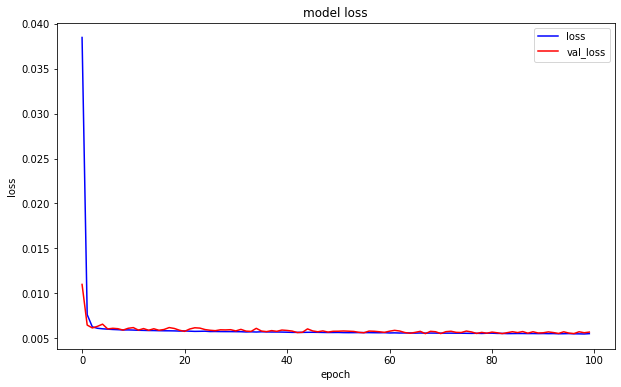

In [61]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'],color='b')
plt.plot(history.history['val_loss'],'r')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper right')

In [62]:
for i in range(20):
  locals()['X'+str(i+1)]=sc_X.fit_transform(locals()['W'+str(i+1)])        #scaling each test well

  locals()['y'+str(i+1)]=model.predict(locals()['X'+str(i+1)])             #model prediction of DTSM (scaled)
  locals()['y'+str(i+1)] =SC_Y.inverse_transform(locals()['y'+str(i+1)])   #rescaling to GET tagret DTSM


In [63]:
len(y1),len(y2),len(y3),len(y4),len(y5),len(y6),len(y7),len(y8),len(y9),len(y10),len(y1),len(y12),len(y20)   #predicted DTSM 

(10745,
 5135,
 1401,
 1737,
 1893,
 1291,
 5031,
 16926,
 24122,
 2019,
 10745,
 12846,
 3671)

In [64]:
len(W1),len(W2),len(W3),len(W4),len(W5),len(W6),len(W7),len(W8),len(W9),len(W10),len(W1),len(W12),len(W20)  

(10745,
 5135,
 1401,
 1737,
 1893,
 1291,
 5031,
 16926,
 24122,
 2019,
 10745,
 12846,
 3671)

In [65]:
for i in range(20):
    locals()["df"+str(i+1)]=pd.DataFrame(locals()['y'+str(i+1)],columns=['DTSM'],index=locals()['W'+str(i+1)].index)  #converting prediction data frame column name is DTSM
                                                                                                                      #indexing is accoring to corresponding Depth

**DTSM visualization for some 10 test well logs**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


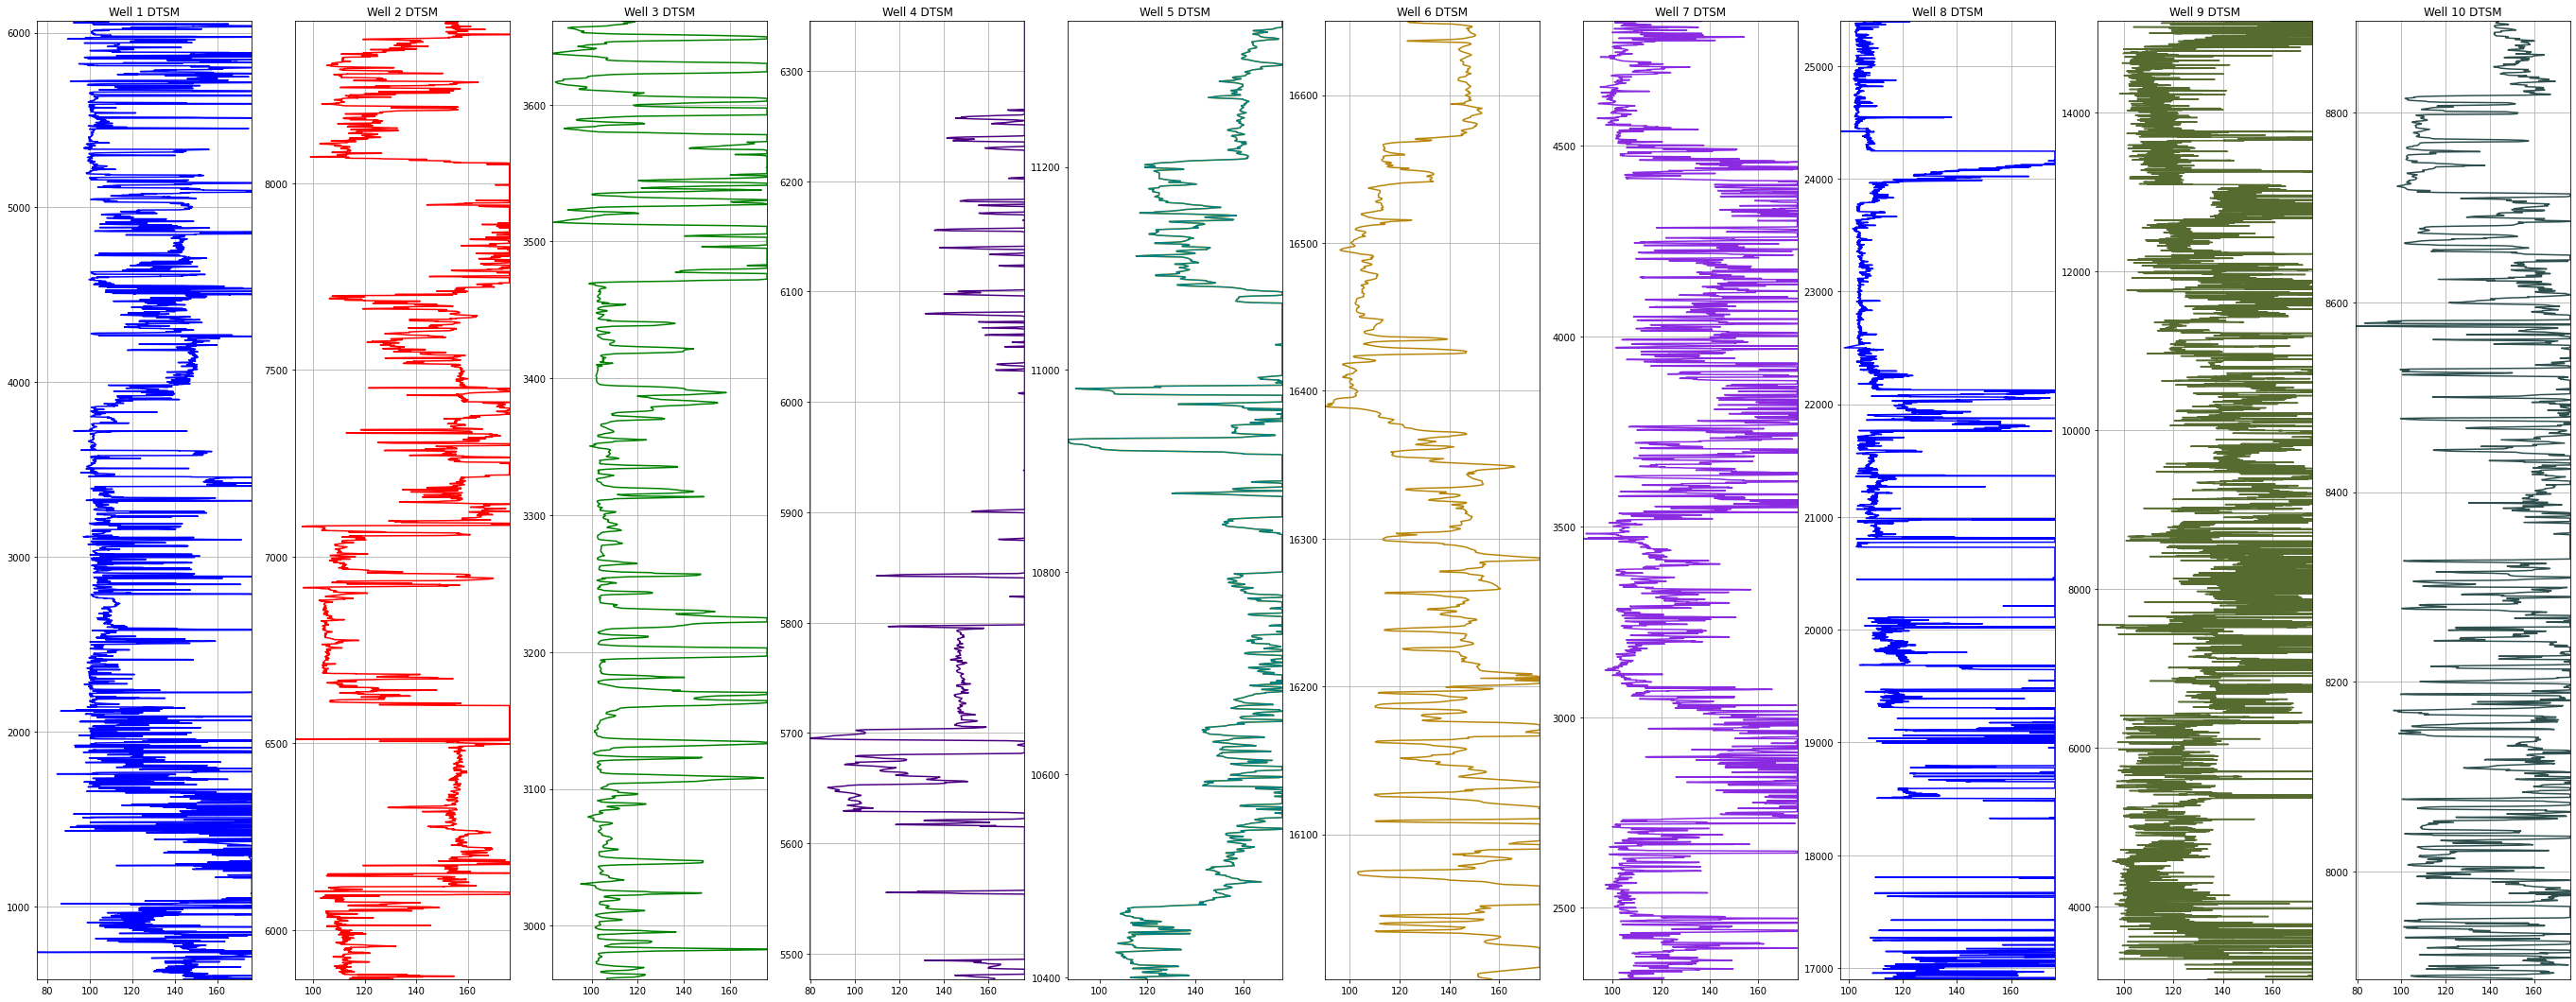

In [67]:
plt.figure(figsize=(48, 220))

plt.subplot(10,10,1)
plt.plot(df1.DTSM, df1.index.values, color = "b") 
plt.title("Well 1 DTSM") 
plt.xlim(df1.DTSM.min(), df1.DTSM.max()) 
plt.ylim(df1.index.values.min(), df1.index.values.max())
plt.grid()

plt.subplot(10,10,2)
plt.plot(df2.DTSM, df2.index.values, color = "r") 
plt.title("Well 2 DTSM") 
plt.xlim(df2.DTSM.min(), df2.DTSM.max()) 
plt.ylim(df2.index.values.min(), df2.index.values.max())
plt.grid()

plt.subplot(10,10,3)
plt.plot(df3.DTSM, df3.index.values, color = "g") 
plt.title("Well 3 DTSM") 
plt.xlim(df3.DTSM.min(), df3.DTSM.max()) 
plt.ylim(df3.index.values.min(), df3.index.values.max())
plt.grid()

plt.subplot(10,10,4)
plt.plot(df4.DTSM, df4.index.values, color = "indigo") 
plt.title("Well 4 DTSM") 
plt.xlim(df4.DTSM.min(), df4.DTSM.max()) 
plt.ylim(df4.index.values.min(), df4.index.values.max())
plt.grid()

plt.subplot(10,10,5)
plt.plot(df5.DTSM, df5.index.values, color = "orange") 
plt.title("Well 5 DTSM") 
plt.xlim(df5.DTSM.min(), df5.DTSM.max()) 
plt.ylim(df5.index.values.min(), df5.index.values.max())
plt.grid()

plt.subplot(10,10,5)
plt.plot(df5.DTSM, df5.index.values, color = "teal") 
plt.title("Well 5 DTSM") 
plt.xlim(df5.DTSM.min(), df5.DTSM.max()) 
plt.ylim(df5.index.values.min(), df5.index.values.max())
plt.grid()

plt.subplot(10,10,6)
plt.plot(df6.DTSM, df6.index.values, color = "darkgoldenrod") 
plt.title("Well 6 DTSM") 
plt.xlim(df6.DTSM.min(), df6.DTSM.max()) 
plt.ylim(df6.index.values.min(), df6.index.values.max())
plt.grid()

plt.subplot(10,10,7)
plt.plot(df7.DTSM, df7.index.values, color = "blueviolet") 
plt.title("Well 7 DTSM") 
plt.xlim(df7.DTSM.min(), df7.DTSM.max()) 
plt.ylim(df7.index.values.min(), df7.index.values.max())
plt.grid()

plt.subplot(10,10,8)
plt.plot(df8.DTSM, df8.index.values, color = "B") 
plt.title("Well 8 DTSM") 
plt.xlim(df8.DTSM.min(), df8.DTSM.max()) 
plt.ylim(df8.index.values.min(), df8.index.values.max())
plt.grid()

plt.subplot(10,10,9)
plt.plot(df9.DTSM, df9.index.values, color = "darkolivegreen") 
plt.title("Well 9 DTSM") 
plt.xlim(df9.DTSM.min(), df9.DTSM.max()) 
plt.ylim(df9.index.values.min(), df9.index.values.max())
plt.grid()

plt.subplot(10,10,10)
plt.plot(df10.DTSM, df10.index.values, color = "darkslategray") 
plt.title("Well 10 DTSM") 
plt.xlim(df10.DTSM.min(), df10.DTSM.max()) 
plt.ylim(df10.index.values.min(), df10.index.values.max())
plt.grid()

In [71]:
from google.colab import files
df1.to_excel('302460e3021a_TGS.xlsx') 
files.download("302460e3021a_TGS.xlsx")

df2.to_excel('0a7822c59487_TGS.xlsx') 
files.download("0a7822c59487_TGS.xlsx")

df3.to_excel('3369b6f8fb6f_TGS.xlsx') 
files.download("3369b6f8fb6f_TGS.xlsx")

df4.to_excel('638f2cc65681_TGS.xlsx') 
files.download("638f2cc65681_TGS.xlsx")

df5.to_excel('7595ba9fb314_TGS.xlsx') 
files.download("7595ba9fb314_TGS.xlsx")

df6.to_excel('84c5fb9cc880_TGS.xlsx') 
files.download("84c5fb9cc880_TGS.xlsx")

df7.to_excel('8e37531ba266_TGS.xlsx') 
files.download("8e37531ba266_TGS.xlsx")

df8.to_excel('94c1f5cae85c_TGS.xlsx') 
files.download("94c1f5cae85c_TGS.xlsx")

df9.to_excel('ed48bda2217f_TGS.xlsx') 
files.download("ed48bda2217f_TGS.xlsx")

df10.to_excel('34a80ab7a5fa_TGS.xlsx') 
files.download("34a80ab7a5fa_TGS.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
df11.to_excel('00d02be79f49_TGS.xlsx') 
files.download("00d02be79f49_TGS.xlsx")

df12.to_excel('113412eec2a6_TGS.xlsx') 
files.download("113412eec2a6_TGS.xlsx")

df13.to_excel('1684cc35f399_TGS.xlsx') 
files.download("1684cc35f399_TGS.xlsx")

df14.to_excel('20372701d5e2_TGS.xlsx') 
files.download("20372701d5e2_TGS.xlsx")

df15.to_excel('2f96a5f92418_TGS.xlsx') 
files.download("2f96a5f92418_TGS.xlsx")

df16.to_excel('63250f7d463b_TGS.xlsx') 
files.download("63250f7d463b_TGS.xlsx")

df17.to_excel('ae16a9f64878_TGS.xlsx') 
files.download("ae16a9f64878_TGS.xlsx")

df18.to_excel('eed1e9537976_TGS.xlsx') 
files.download("eed1e9537976_TGS.xlsx")

df19.to_excel('fca03aa6acde_TGS.xlsx') 
files.download("fca03aa6acde_TGS.xlsx")

df20.to_excel('ff7845ea074d_TGS.xlsx') 
files.download("ff7845ea074d_TGS.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>